## Dependencies

In [1]:
## libraries
import os
import sys
import numpy as np
import pandas as pd
import dask.dataframe as dd
from concurrent.futures import ThreadPoolExecutor
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt

## modules
sys.path.insert(0, './')
from test_data import TestSpatialPointMean

## Initalization

In [2]:
## test data paths
cwd = os.getcwd()
path_a = '/data/test-data-a.csv'
path_b = '/data/test-data-b.csv'
path_c = '/data/test-data-c.csv'

## gtfs data
iata_path = (
    ('NYC', cwd + '/routes/us-east/nyc/'),
    ('PHL', cwd + '/routes/us-east/phl/'),
    ('DCA', cwd + '/routes/us-east/dca/'),
    ('BOS', cwd + '/routes/us-east/bos/'),
    ('PIT', cwd + '/routes/us-east/pit/'),
    ('LAX', cwd + '/routes/us-west/lax/'),
    ('SFO', cwd + '/routes/us-west/sfo/'),
    ('SAN', cwd + '/routes/us-west/san/'),
    ('SEA', cwd + '/routes/us-west/sea/'),
    ('SMF', cwd + '/routes/us-west/smf/'),
    ('PDX', cwd + '/routes/us-west/pdx/'),
    ('ATL', cwd + '/routes/us-suth/atl/'),
    ('MIA', cwd + '/routes/us-suth/mia/'),
    ('TPA', cwd + '/routes/us-suth/tpa/'),
    ('SDF', cwd + '/routes/us-suth/sdf/'),
    ('BNA', cwd + '/routes/us-suth/bna/'),
    ('MSP', cwd + '/routes/us-cent/msp/'),
    ('STL', cwd + '/routes/us-cent/stl/'),
    ('MSN', cwd + '/routes/us-cent/msn/'),
    ('CMH', cwd + '/routes/us-cent/cmh/'),
    ('DSM', cwd + '/routes/us-cent/dsm/'),
    ('DEN', cwd + '/routes/us-mntn/den/'),
    ('PHX', cwd + '/routes/us-mntn/phx/'),
    ('SAT', cwd + '/routes/us-mntn/sat/'),
    ('AUS', cwd + '/routes/us-mntn/aus/'),
    # ('BIL', cwd + '/routes/us-mntn/bil/'),
    ('YUL', cwd + '/routes/ca-east/yul/'),
    ('YYZ', cwd + '/routes/ca-east/yyz/'),
    ('YHM', cwd + '/routes/ca-east/yhm/'),
    ('YHZ', cwd + '/routes/ca-east/yhz/'),
    ('YQT', cwd + '/routes/ca-east/yqt/'),
    ('YVR', cwd + '/routes/ca-west/yvr/'),
    ('YYC', cwd + '/routes/ca-west/yyc/'),
    ('YEG', cwd + '/routes/ca-west/yeg/'),
    ('YXE', cwd + '/routes/ca-west/yxe/'),
    ('AMS', cwd + '/routes/eu-west/ams/'),
    # ('ARN', cwd + '/routes/eu-west/arn/'),
    ('HEL', cwd + '/routes/eu-west/hel/'),
    ('DUB', cwd + '/routes/eu-west/dub/'),
    ('FCO', cwd + '/routes/eu-west/fco/'),
    # ('WAW', cwd + '/routes/eu-cent/waw/'),
    # ('KRK', cwd + '/routes/eu-cent/krk/'),
    # ('GDN', cwd + '/routes/eu-cent/gdn/'),
    ('PRG', cwd + '/routes/eu-cent/prg/'),
    ('SYD', cwd + '/routes/oc-full/syd/'),
    ('BNE', cwd + '/routes/oc-full/bne/'),
    ('ADL', cwd + '/routes/oc-full/adl/'),
    ('AKL', cwd + '/routes/oc-full/akl/'),
    ('CHC', cwd + '/routes/oc-full/chc/')
    # ('DEL', cwd + '/routes/as-full/del/')
)

## Spatial Point Error

In [ ]:
## compute mean errors
def means(args):
    i, j, data, tspm = args
    try:
        results = tspm.shapes_path_loop(
            data = data.compute(),
            iata_path = iata_path,
            dist_thres = j
        )

        ## unweighted mean error
        n_unweight = len(results)
        mean_unweight = 100 - sum(
            k['accuracy'] for k in results.values()
        ) / n_unweight if n_unweight > 0 else None

        ## weighted mean error
        n_weight = sum(k['observations'] for k in results.values())
        mean_weight = 100 - sum(
            k['accuracy'] * k['observations'] / n_weight for k in results.values()
        ) if n_weight > 0 else None

        return j, f'{i}_mean_unweight', mean_unweight, f'{i}_mean_weight', mean_weight

    except Exception as e:
        print(f"Error in processing {i} with dist_thres {j}: {str(e)}")
        return j, f'{i}_mean_unweight', None, f'{i}_mean_weight', None

## init dask client and cluster
cluster = LocalCluster(n_workers = 4, threads_per_worker = 1)  ## adj as needed
client = Client(cluster)

## init vars and paths
dist = list(range(0, 101, 1))
data_mean = pd.DataFrame()
paths = [path_c]

## test data
for i, path in enumerate(paths, start = 1):
    tspm = TestSpatialPointMean()
    dtype = {
        'iata_id': str,
        'vehicle_id': str,
        'trip_id': str,
        'route_id': str,
        'latitude': float,
        'longitude': float
    }
    usecols = [i for i in dtype.keys()]
    data = dd.read_csv(
        urlpath = cwd + path,
        usecols = usecols,
        dtype = dtype
    )

    ## reset data_mean for each path
    data_mean = pd.DataFrame()

    ## parallel execution of means
    with ThreadPoolExecutor(max_workers=4) as executor:
        for count, result in enumerate(executor.map(means, [(path, j, data, tspm) for j in dist]), start=1):
            j, k_1, mean_unweight, k_2, mean_weight = result
            data_mean.at[j, k_1] = mean_unweight
            data_mean.at[j, k_2] = mean_weight

            ## save every 1 iterations or on the last iteration
            if count % 1 == 0 or count == len(dist):
                base_name = os.path.splitext(os.path.basename(path))[0]
                filename = f"test-mean-{base_name}-{count}.csv"
                output_dir = "./output"
                os.makedirs(output_dir, exist_ok = True)
                
                full_path = os.path.join(output_dir, filename)
                data_mean.to_csv(full_path)
                print(f"Saved partial results to {full_path}")


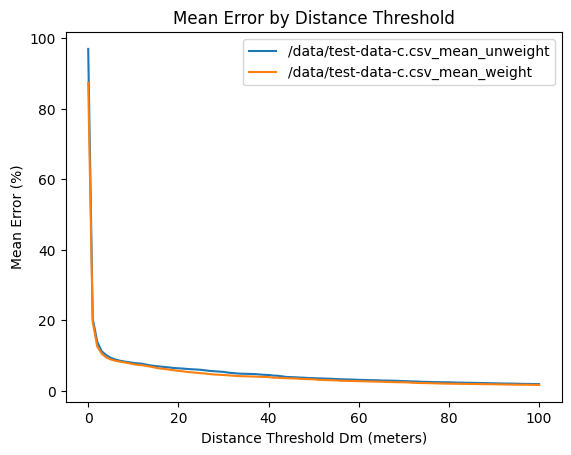

In [3]:
## pre-process plot
data_mean = pd.read_csv(
    filepath_or_buffer = './output/mean-data-c-101.csv',  ## manually test a b c as needed
    index_col = 0
)

## plot
plot = data_mean.plot(
    title = 'Mean Error by Distance Threshold',
    xlabel = 'Distance Threshold Dm (meters)',
    ylabel = 'Mean Error (%)'
)


## Temporal Contiguity

In [4]:
## test data
paths = (path_a, path_b, path_c)

data_obs = pd.DataFrame()
for i in paths:
    data = pd.read_csv(
        filepath_or_buffer = cwd + i,
        low_memory = False,
        dtype = {
            'vehicle_id': str,
            'trip_id': str,
            'route_id': str,
            'latitude': float,
            'longitude': float,
            'datetime': int,
            'duration': int
            }
        )

    ## preprocess datetime
    data['datetime'] = pd.to_datetime(data['datetime'], unit='s')
    data['hour'] = data['datetime'].dt.hour

    ## count observations per hour
    obs_per_hr = data.groupby('hour').size()
    obs_per_hr.index += 1
    
    data_obs[i] = obs_per_hr

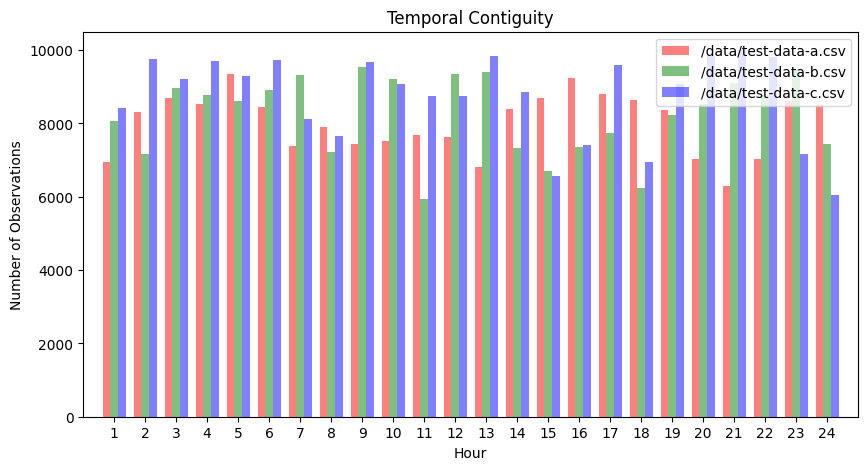

In [5]:
## preprocess plot
colors = ['red', 'green', 'blue']
width = 0.25
bins = np.arange(1, 25)

## plot
plt.figure(figsize = (10, 5))
for k, column in enumerate(data_obs.columns):
    plt.bar(bins - width + k * width, data_obs[column], width=width, alpha=0.5, color=colors[k], label=column)

## plot settings
plt.title('Temporal Contiguity')
plt.xlabel('Hour')
plt.ylabel('Number of Observations')
plt.xlim(0, 25)
plt.xticks(bins)
plt.legend()

## view
plt.show()